In [12]:
#############################################################
# Compile `main.cu` to `file.exe`
# Commented out because we don't want to run it all the time
#############################################################
!nvcc -w functions.cu main.cu -o file

functions.cu
tmpxft_00003a58_00000000-10_functions.cudafe1.cpp
main.cu
tmpxft_00003a58_00000000-14_main.cudafe1.cpp
   Creating library file.lib and object file.exp


In [13]:
#############################################################
# Load python dependencies
# If package cannot be resolved from pylance, reload the interpreter
#############################################################
import numpy as np
import matplotlib.pyplot as plt
import utils
import os.path
import scipy.stats as stats

In [14]:
#############################################################
# Generate and write detuning data to file
#############################################################
# Write 1D numpy array to file
detuning_values_1d = utils.gen_same_pop(2, 1000, None)
print("Detuning data:", detuning_values_1d)
np.savetxt("Detuning.dat", detuning_values_1d, delimiter="\t")

# Example: write 2D numpy array to file
# values_2d = np.array([
#     [10.0, 20.0, 40.0],
#     [10.0, 20.0, 50.0],
#     [10.0, 20.0, 60.0]
# ])
# np.savetxt("values_2d.dat", values_2d, delimiter="\t")

Detuning data: [   2.69979606 1000.        ]


# Run simulation

To run a single system, use terminal: 

         k  n_tot theta,phi g gamma chi kap t_end t_num handle

file.exe 20 100000 0.5 0.0 1.6 0.0 0.0 160 0.5 600000 k20N5_0.5_0_kappa160

## Suggested file naming convention:
k{num_ens}N{order of magnitude of n_total}_{theta_phi}_{other params}

E.g., k5N5_1_0_kappa160

The below block of code is useful for running multiple jobs

In [15]:
#############################################################
# Test 2: effect of inhomogeneous broadening (intermediate case)
#############################################################
max_det = 280
detunings = [[0,max_det],[0,max_det/2],[0,2*max_det/3],[0,max_det/2,max_det],
             [0,max_det/3], [0,max_det/3, max_det], 
             [0, 2*max_det/3], [0, 2*max_det/3, max_det]]
num_ens = 3
N_ens = 5000
theta_0 = 1
phi_0 = 0.0
coup_a_0 = 1.0
gamma_a_0 = 0.0
chi_a_0 = 0.0
kappa_c_0 = 100.0
t_max = 0.2
t_num = 60000
run = 0
det_dict = {}
handle_list = []

for i in range(len(detunings)):
    # np.savetxt(f"Detuning.dat", detunings[i], delimiter="\t")
    num_ens = len(detunings[i])
    params = f'{num_ens} {N_ens*num_ens} {theta_0} {phi_0} {coup_a_0} {gamma_a_0} {chi_a_0} {kappa_c_0} {t_max} {t_num}'
    handle = f'k{num_ens}N{N_ens*num_ens}det{max_det}_{theta_0}_{coup_a_0}_{kappa_c_0}_{i+1}' # Add extra notes as needed
    det_dict[handle] = detunings[i]
    handle_list.append(handle)
    print(f"************************* Run {i+1} *************************")
    print(f"Handle: {handle} ")
    #utils.runcmd(f'file.exe {params} {handle}')
    print("\n")

************************* Run 1 *************************
Handle: k2N10000det280_1_1.0_100.0_1 


************************* Run 2 *************************
Handle: k2N10000det280_1_1.0_100.0_2 


************************* Run 3 *************************
Handle: k2N10000det280_1_1.0_100.0_3 


************************* Run 4 *************************
Handle: k3N15000det280_1_1.0_100.0_4 


************************* Run 5 *************************
Handle: k2N10000det280_1_1.0_100.0_5 


************************* Run 6 *************************
Handle: k3N15000det280_1_1.0_100.0_6 


************************* Run 7 *************************
Handle: k2N10000det280_1_1.0_100.0_7 


************************* Run 8 *************************
Handle: k3N15000det280_1_1.0_100.0_8 




[0, 280]
[0, 140.0]
[0, 140.0, 280]


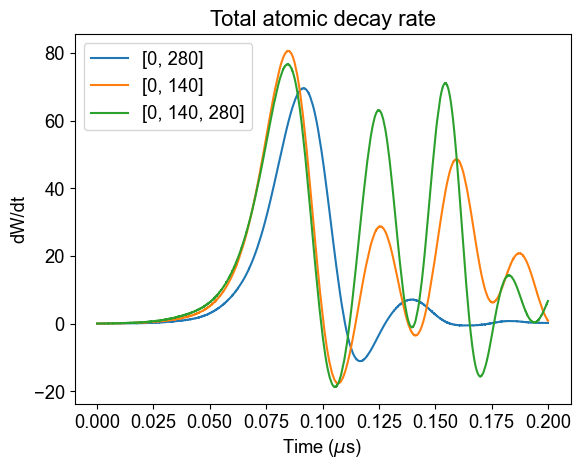

<Figure size 650x420 with 0 Axes>

In [17]:
plot_good = 0 # Change to 1 once sure the result is good
results = [utils.read_results(handle) for handle in handle_list]
sz_list = [results[i][1] for i in range(len(handle_list))]
dt = results[0][0][-1]/np.size(results[0][0])
plt.rcParams.update({'font.size': 13.2})
plt.rcParams["font.family"] = "Arial"
from matplotlib import rc
fig = plt.figure()
ax = fig.subplots(1, 1)
plt.figure(figsize=(6.5,4.2))
ax.set_title("Total atomic decay rate")
ax.set_ylabel(r"dW/dt")
ax.set_xlabel(r"Time ($\mu$s)")
for i in [0,1,3]:
    W = utils.Wt(results[i][1])
    I = -utils.diffentiate(dt, W)
    print(detunings[i])
    ax.plot(results[0][0][:-1], I, label=[int(k) for k in detunings[i]])
    # ax.set_yscale('log')
ax.legend()
plt.savefig(f"test2_dwdt_{plot_good}", dpi=300)

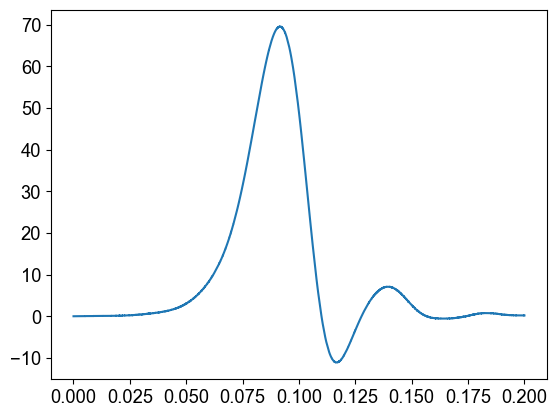

In [11]:
W = utils.Wt(results[0][1])
dt = results[0][0][-1]/np.size(results[0][0])
I = -utils.diffentiate(dt, W)
plt.plot(results[0][0][:-1], I)

In [2]:
#############################################################
# Test 3: Find critical detuning
# Criterion 1: Td <1.05 Td(0)
# Criterion 2: sz_delta < -0.8
# System {-d, 0, d}
#############################################################
N_tot_range = np.linspace(20000, 800000, 40)[::-1].astype(int) # Start with the largest ensemble
num_ens = 3
theta_0 = 1
phi_0 = 0.0
coup_a_0 = 1.0
gamma_a_0 = 0.0
chi_a_0 = 0.0
kappa_c_0 = 100.0
t_max = 0.2
t_num = 60000
det_dict = {}
handle_list = []
delta_min = 0
delta_max = 375
delta_cur = delta_max # Temporary variable
cor_cri = 0.99
tol = 1e-3 # Tolerance 0.001
delta_crit = [] # Storing critical detunings satisfying crit

for N_tot in N_tot_range:
    # Run initial test to see if the current range is ok
    crit1 = 0
    found1 = False
    run = 0
    max_run = 10
    delta_min = 0
    delta_max = delta_cur # Smaller ensembles have smaller critical detuning
    
    # Initial check: crit1 fails at delta_max
    while(True):
        print(delta_max)
        detuning_max = [0, -delta_max, delta_max]
        np.savetxt("Detuning.dat", detuning_max, delimiter="\t")
        params = f'{num_ens} {N_tot} {theta_0} {phi_0} {coup_a_0} {gamma_a_0} {chi_a_0} {kappa_c_0} {t_max} {t_num}'
        handle_max = f'k{num_ens}N{N_tot}det{delta_max}_{theta_0}_{coup_a_0}_{kappa_c_0}_test3'
        print(handle_max)
        # Check if file already exists
        if os.path.isfile(f"Result_Sz_{handle_max}.dat") == False:
            utils.runcmd(f'file.exe {params} {handle_max}')
        else:
            print("File exits, skipping simulation")
        # utils.runcmd(f'file.exe {params} {handle_max}')
        result = utils.read_results(handle_max)
        cor = np.corrcoef(result[1][:,0],result[1][:,1])[0][1]
        
        if np.abs(cor-cor_cri) < tol: # delta_max is the critical detuning for crit1
            delta_crit.append(delta_max)
            found1 = True
            delta_cur = delta_max
            print(f"delta_crit1 has been found at boundary {delta_max}")
            break
        elif cor < cor_cri:
            break
        elif cor > cor_cri: # delta_max is smaller than critical detuning for crit1
            delta_max += 100
            print(f"delta_max smaller than critical, increase by 100 to {delta_max}")
        # break (auto) delta_max is larger than critical detuning for crit 1
    
    # Start searching by binary
    while((found1== False) and run<max_run and delta_max-delta_min>5):
        run += 1
        delta_mid = int((delta_max + delta_min)/2)
        detuning_mid = [0, -delta_mid, delta_mid]
        np.savetxt("Detuning.dat", detuning_mid, delimiter="\t")   
        handle_mid = f'k{num_ens}N{N_tot}det{delta_mid}_{theta_0}_{coup_a_0}_{kappa_c_0}_test3' # Add extra notes as needed
        handle_list.append(handle_mid)
        det_dict[handle_mid] = detuning_mid
        print(f"************************* {N_tot} Run {run} Detuning {delta_mid} *************************")
        print(f"Handle: {handle_mid}")
        if os.path.isfile(f"Result_Sz_{handle_mid}.dat") == False:
            utils.runcmd(f'file.exe {params} {handle_mid}')
        else:
            print("File exits, skipping simulation")
        # utils.runcmd(f'file.exe {params} {handle_mid}')
        result = utils.read_results(handle_mid)
        cor = np.corrcoef(result[1][:,0],result[1][:,1])[0][1]
        if np.abs(cor - cor_cri) < tol:
            delta_crit.append(delta_mid)
            found1 = True
            delta_cur = delta_mid
            print(f"delta_crit1 has been found at run {run}: {delta_mid}, {cor}")
            break
        elif cor < cor_cri:
            delta_max = delta_mid
            print(f"Detuning {delta_mid} too large, {cor}, next round")
        elif cor > cor_cri:
            delta_min = delta_mid
            print(f"Detuning {delta_mid} too small, {cor}, next round")
    
    if found1 == False:
        delta_mid = int((delta_min + delta_max)/2)
        delta_crit.append(delta_mid)
        found1 = True
        delta_cur = delta_mid
        print(f"Unable to resolve within max_iter, settle at {delta_mid} with cor ~{cor}")

375
k3N800000det375_1_1.0_100.0_test3
File exits, skipping simulation
delta_crit1 has been found at boundary 375
375
k3N780000det375_1_1.0_100.0_test3
File exits, skipping simulation
delta_crit1 has been found at boundary 375
375
k3N760000det375_1_1.0_100.0_test3
File exits, skipping simulation
************************* 760000 Run 1 Detuning 187 *************************
Handle: k3N760000det187_1_1.0_100.0_test3
File exits, skipping simulation
Detuning 187 too small, 0.9987014459553126, next round
************************* 760000 Run 2 Detuning 281 *************************
Handle: k3N760000det281_1_1.0_100.0_test3
File exits, skipping simulation
Detuning 281 too small, 0.995524916637658, next round
************************* 760000 Run 3 Detuning 328 *************************
Handle: k3N760000det328_1_1.0_100.0_test3
File exits, skipping simulation
Detuning 328 too small, 0.9926473867296693, next round
************************* 760000 Run 4 Detuning 351 *************************
Handle

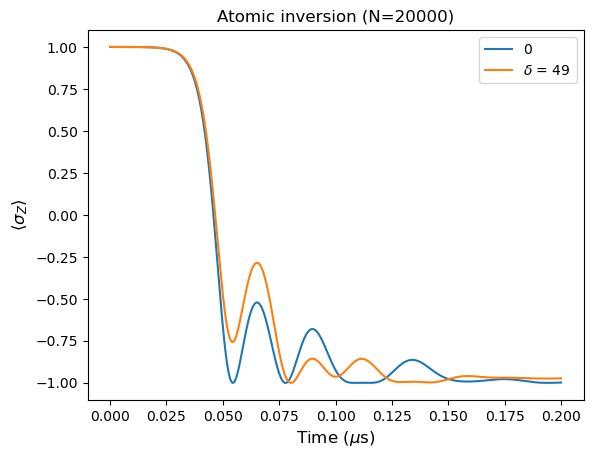

In [3]:
plt.plot(result[0], result[1][:,0], label="0")
plt.plot(result[0], result[1][:,1], label=f"$\delta$ = {delta_max}")
plt.title(f"Atomic inversion (N={N_tot})", fontsize=12)
plt.xlabel(r"Time ($\mu$s)", fontsize=12)
plt.ylabel(r"$\langle \sigma_Z \rangle$", fontsize=12)
# plt.text(0.12,0.1, f"Correlation: {round(cor, 4)}")
plt.legend()

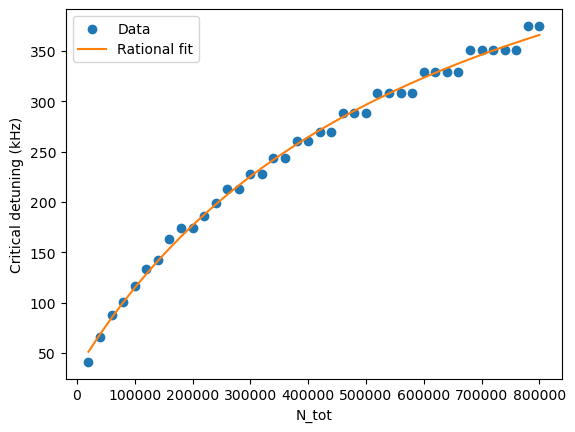

In [6]:
plt.scatter(N_tot_range, delta_crit, label="Data")
# plt.plot(N_tot_range, predict_Y_log(N_tot_range))
# plt.plot(N_tot_range, predict_Y_quad(N_tot_range))
plt.plot(N_tot_range, predict_Y_hyp(N_tot_range),label="Rational fit", color="#ff7f0e")
plt.ylabel("Critical detuning (kHz)")
plt.xlabel("N_tot")
plt.legend()
# delta_crit
# plt.scatter(N_tot_range, delta_crit)
# plt.plot(N_tot_range, predict_Y(N_tot_range))

In [8]:

#from sklearn.metrics import r2_score
from scipy.optimize import curve_fit

X = np.array(N_tot_range)
Y = np.array(delta_crit)

def quadratic_function(X, a, b, c):
    return a * X ** 2 + b * X + c

def logarithmic_function(X, a, b) :
    return a * np.log(X) + b

def hyperbola_function(x, a, b, c):
    return a / (x - b) + c

log_co, _ = curve_fit(logarithmic_function, X, Y)
quad_co, _ = curve_fit(quadratic_function, X, Y)
hyp_co, _ = curve_fit(hyperbola_function, X, Y)

print("Optimized parameters (log):", log_co)
print("Optimized parameters (quad):", quad_co)
print("Optimized parameters (hyper):", hyp_co)

def predict_Y_log(X):
    return logarithmic_function(X, *log_co)

def predict_Y_quad(X):
    return quadratic_function(X, *quad_co)

def predict_Y_hyp(X):
    return hyperbola_function(X, *hyp_co)

#print("R-squared:", r2_score(Y, predict_Y(X)))


Optimized parameters (log): [  101.74139845 -1039.89907725]
Optimized parameters (quad): [-3.61048609e-10  6.77617082e-04  5.04131583e+01]
Optimized parameters (hyper): [-3.70265609e+08 -6.24089004e+05  6.25999809e+02]


# Analyze & Plot
todo:  import util functions return predict Td
write block to plot with Td and found Td

In [ ]:
#############################################################
# Read in the results file
# Returns: 
#         [0]: time steps
#         [1]: sz
#         [2]: coherence
#         [3]: photons
#############################################################
results = []
detunings = []
for i in range(np.size(handle_list)):
    results.append(utils.read_results(handle_list[i])) # Input: file handle
    detunings.append(det_dict[handle_list[i]])
# results = utils.read_results(handle_list[0]) # Input: file handle
print(detunings)

In [ ]:
#############################################################
# Plots intracavity field
#############################################################
for i in [0,6,7]:
    end_ind = utils.cut_time(results[0][0], -1)
    print(end_ind)
    plt.plot(results[i][0], results[i][3], label=[int(k) for k in detunings[i]])
plt.title("Intracavity photon", fontsize=12)
plt.xlabel(r"Time ($\mu$s)", fontsize=12)
plt.ylabel(r"$\langle a^\dagger a\rangle$", fontsize=12)
plt.legend()

In [ ]:
# More code on diff photons
ada_03 = (results[3][3]-results[1][3])/results[1][3]*100
ada_13 = (results[5][3]-results[4][3])/results[4][3]*100
ada_23 = (results[7][3]-results[6][3])/results[6][3]*100
plt.plot(results[0][0], ada_13, label=r"[0,$\delta/3$, $\delta$]-[0,$\delta/2$]")
plt.plot(results[0][0], ada_03, label=r"[0,$\delta/2$, $\delta$]-[0,$\delta/3$]")
plt.plot(results[0][0], ada_23, label=r"[0,$2\delta/3$, $\delta$]-[0,$2\delta/3$]")
plt.title("Intracavity photon difference", fontsize=12)
plt.xlabel(r"Time ($\mu$s)", fontsize=12)
plt.ylabel(r"$\Delta\langle a^\dagger a\rangle (\%)$", fontsize=12)
plt.legend()

In [ ]:
#############################################################
# Line plots for inversion and coherence
#############################################################
for i in [0,4,5]:
    if len(detunings[i])<2:
        plt.plot(results[i][0], results[i][1], label=int(detunings[i]))
    else:
        plt.plot(results[i][0], results[i][1][:,0], label=[int(k) for k in detunings[i]])

# Td = utils.findTd(results[0][1], results[0][0])
# print(Td)
plt.title("Atomic inversion (1st class)", fontsize=12)
plt.xlabel(r"Time ($\mu$s)", fontsize=12)
plt.ylabel(r"$\langle \sigma_Z \rangle$", fontsize=12)
plt.legend()

In [ ]:
# The main emission part
sz_03 = results[0][1][:,0]
sz_13 = results[4][1][:,0]
sz_23 = results[5][1][:,0]
plt.plot(results[0][0], sz_03, label=r"[0,$\delta$]")
plt.plot(results[0][0], sz_13, label=r"[0,$\delta/3$]")
plt.plot(results[0][0], sz_23, label=r"[0,$\delta/3$, $\delta$]")

# Td = utils.findTd(results[0][1], results[0][0])
# print(Td)
plt.title("Atomic inversion (1st class)", fontsize=12)
plt.xlabel(r"Time ($\mu$s)", fontsize=12)
plt.ylabel(r"$\langle \sigma_Z \rangle$", fontsize=12)
plt.legend()

In [ ]:
sz_03 = (results[3][1][:,0]-results[1][1][:,0])
sz_13 = (results[5][1][:,0]-results[4][1][:,0])
sz_23 = (results[7][1][:,0]-results[6][1][:,0])
plt.plot(results[0][0], sz_13, label=r"[0,$\delta/3$, $\delta$]-[0,$\delta/3$]")
plt.plot(results[0][0], sz_03, label=r"[0,$\delta/2$, $\delta$]-[0,$\delta/2$]")
plt.plot(results[0][0], sz_23, label=r"[0,$2\delta/3$, $\delta$]-[0,$2\delta/3$]")

# Td = utils.findTd(results[0][1], results[0][0])
# print(Td)
plt.title("Atomic inversion (1st class)", fontsize=12)
plt.xlabel(r"Time ($\mu$s)", fontsize=12)
plt.ylabel(r"$\Delta\langle \sigma_Z \rangle$", fontsize=12)
plt.legend()

In [ ]:
#############################################################
# Line plots for coherence
#############################################################
for i in [5,3,7]:
    if len(detunings[i])<3:
        plt.plot(results[i][0], results[i][2], label=int(detunings[i]))
    else:
        plt.plot(results[i][0], results[i][2][:,2], label=[int(k) for k in detunings[i]])

plt.title("Coherence", fontsize=12)
plt.xlabel(r"Time ($\mu$s)", fontsize=12)
plt.ylabel(r"$\langle \sigma_+^k\sigma_-^0 \rangle$", fontsize=12)
plt.legend()

In [ ]:
utils.plot_heat(results[0],detuning_values_1d[:20], np.rot90(results[1]), -1.0,1.0, 
                "Atom inversion $\langle\sigma_Z\\rangle$", "Time ($\mu$s)", "Detuning (kHz)")

In [ ]:
utils.plot_heat(results[0],detuning_values_1d, np.rot90(results[2]), 0,0.25, 
                "Coherences", "Time ($\mu$s)", "$\langle\sigma_+\sigma_-\\rangle$")

In [ ]:

a = np.rot90(np.asarray([[0,1,2],[3,4,5]]))
print(a)
utils.plot_heat([0,1], [3,2,1], a, 0,6, "na", "na", "na")